# ECBME4070 HW4 - Motion Detection

# Vanshika Sriram and Suheyla Tozan (vs2668, stt2126)

In this homework, you are asked to implement Hassenstein-Reichardt Detector and demonstrate its edge detection capability on the video of a moving bar.
You are given a function that generates the video of the moving bar and are asked to complete the following tasks:
1. Generate right-ward moving bar video of shape `(H, W, T)` (see function docstring for details). Choose a set of parameters for the moving bar generator where the motion of the bar is visually apparent when visualized.
    - You may want to use `matplotlib.pyplot.imshow` for plotting a single frame. 
2. Visualize 5 frames of the moving bar video
3. Implement the Elementary Motion Detection (EMD) variant of the HR detector model (with delay instead of high-pass/low-pass filter). Note that for a video of width `W`, you should have `(W-1)*H` motion detectors (each detector detects motion between two horizontally adjacent pixels), giving you output of shape `(H, W-1, T)`.
4. Visualize input video and output motion for 5 frames, around in a `(2,5)` grid of images where first row correspond to 5 frames of the input, the second row correspond to 5 frames of the HR output.
5. Re-run and visualize output for your HR detector given a _left_-ward moving bar.

**Note**: This assignment can be completed without GPU (CoLab).

### Instructions for Submission
Name your notebook `HW4_YOUR_UNI.ipynb`. Submit your `.ipynb` notebook _AND_ a `.html` version of the same notebook (using `File > Output Notebook As > ...` in JupyterLab or [nbconvert](https://nbconvert.readthedocs.io/en/latest/) otherwise). 

* _Author_: Tingkai Liu, Mehmet Kerem Turkcan
* _Bionet Group, Columbia University_

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [3]:
def generate_input(bar_width=10, width=128, height=32, steps=128, direction='right', speed=1, amplitude=1.):
    '''Create Vertical Moving Bar Stimulus.
        
    Parameters
    ----------
    bar_width: int
        Width of the moving bar
    width: int
        width of the whole window
    height: int
        height of the whole window
    steps: int
        number of steps to generated the input
    direction: str
        - 'left': bar moves left from the right edge
        - 'right': bar moves right from the left edge
    speed: int
        speed at which bar is moving
    amplitude: float
        amplitude of the bar
    
    Returns
    -------
    X: np.ndarray of shape (height, width, steps)
        The height and width dimensions are flipped as per convention for images
        Index a frame of the image at time index t as `X[..., t]`
    '''
    assert direction in ['left', 'right'], \
        "direction should be 'left' or 'right', got {} instead".format(direction)
    X = np.zeros((height,width,steps))

    for i in range(steps):
        x = int(np.floor(width * i * speed / steps))
        xmin = int(np.max((0, x-bar_width)))
        if xmin > X.shape[1]:
            # flew off the screen
            break
        X[:,xmin:x,i] = amplitude

    if direction == 'left':
        return X[...,::-1]
    return X

In [4]:
# TODO: Generate Moving Bar moving left-right using the function above 

moving_bar = generate_input(bar_width=10, width=128, height=32, steps=128, direction='right', speed=1, amplitude=1.)
moving_bar1 = generate_input(bar_width=10, width=128, height=32, steps=128, direction='left', speed=1, amplitude=1.)

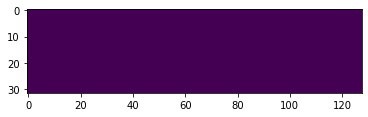

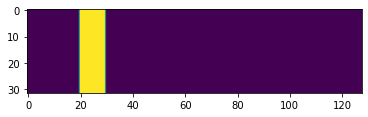

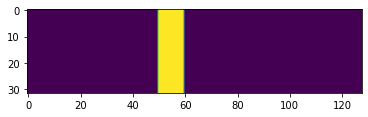

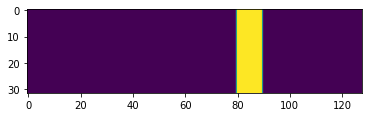

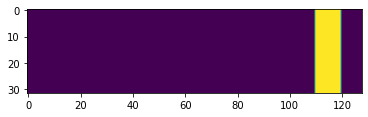

In [5]:
# TODO: Visualize 5 frames of the moving bar to show motion

steps = 128
for i in range(0, steps, 30):
    plt.imshow(moving_bar[:,:,i])
    plt.show()

In [6]:
# TODO: Implement HR Detector

def delay(x, n): # implement delay for index n (note n could be negative)
    height, width, time = x.shape
    
    output = np.zeros_like(x)
    for i in range(time):
        if(i>n):
            output[:,:,i] = x[:,:,i-n]
        else:
            continue
    
    return output
       
def HR_Detector(x, direction, #input
                func_left=lambda x: delay(x, 0), #transformation for the left pixel
                func_right=lambda x: delay(x, 10), # transformation for the right pixel
               ):
        
    first = func_left(x)
    second = func_right(x)
    
    height, width, time = x.shape
    output = np.zeros((height, width-1, time))
    
    if direction == "left":
        for w in range(len(x[1])-1):
            output[:,w,:] = first[:,w,:] * second[:,w+1,:]
        
    elif direction == "right":
        for w in range(len(x[1])-1):
            output[:,w,:] = first[:,w+1,:] * second[:,w,:]
            
    return output

In [7]:
#Function to make subplots 

def make_subplot(a,b): #a = moving bar, b = detector
    
    figure_list = []

    for i in range(0, steps, 30):
        plt.imshow(a[:,:,i])
        figure_list.append(a[:,:,i])

    for i in range(0, steps, 30):
        plt.imshow(b[:,:,i])
        figure_list.append(b[:,:,i])

    fig, axs = plt.subplots(5, 2,figsize=(25,15))
    fig.tight_layout(pad=2.5)
    
    for i in range(5):
        axs[i,0].imshow(figure_list[i])
    
    for i in range(5):
        axs[i,1].imshow(figure_list[i+5])

    return plt.show()

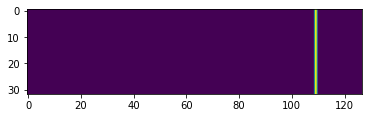

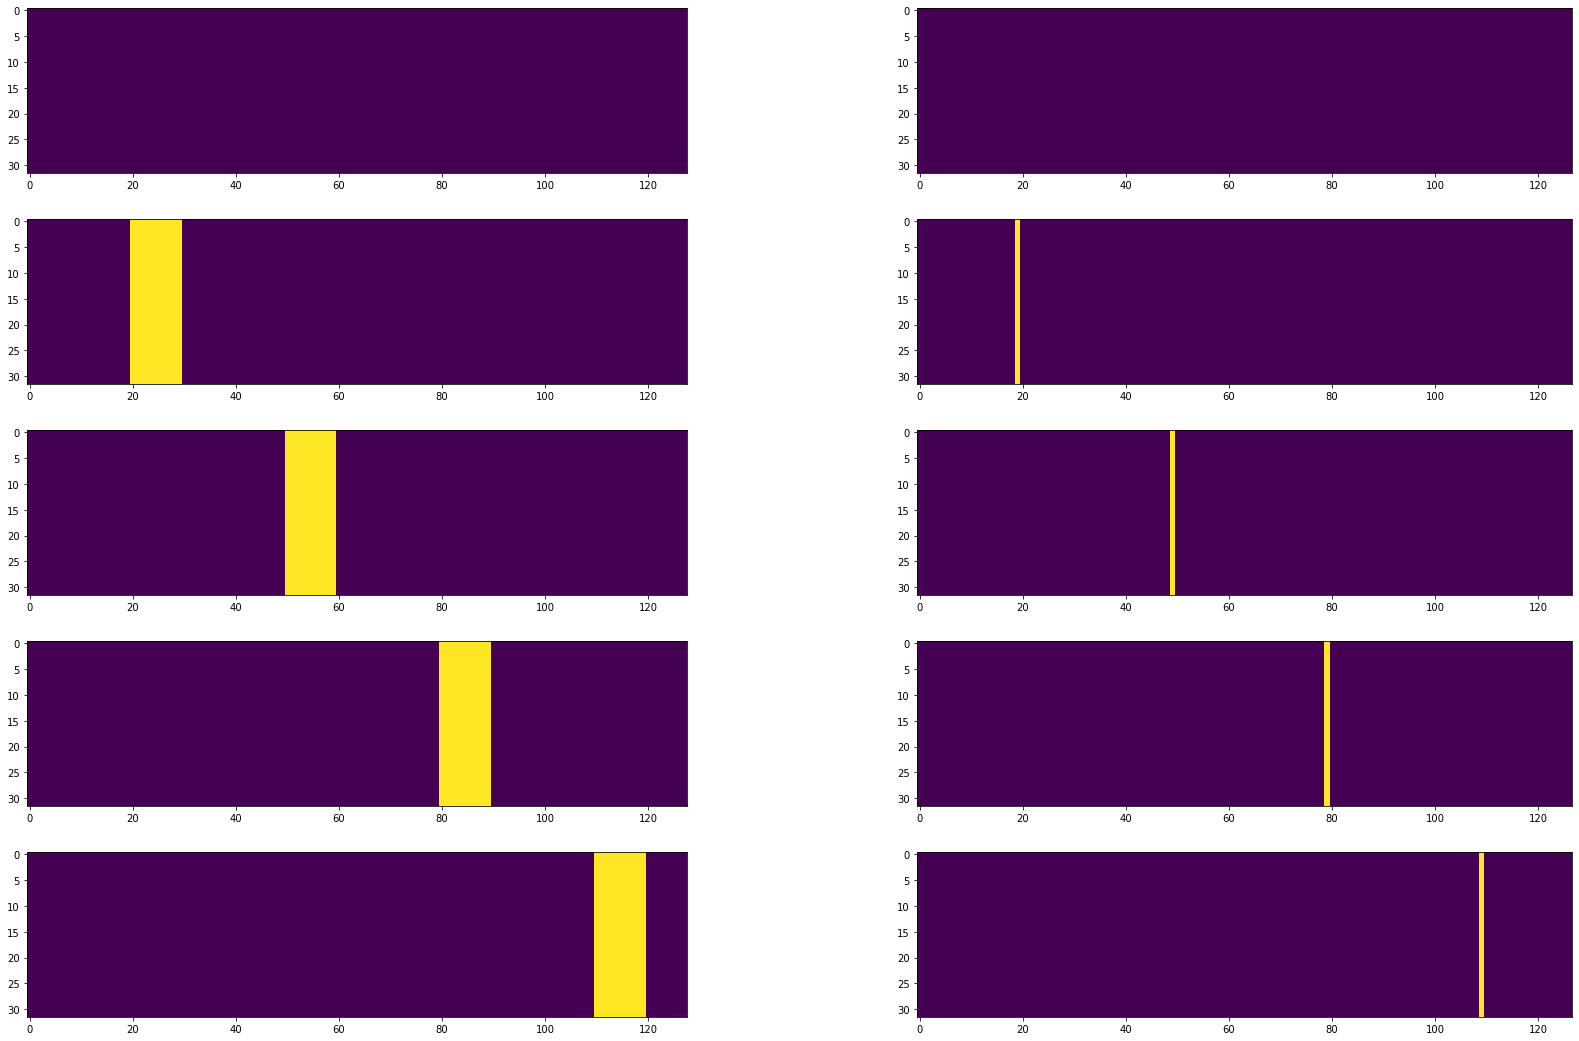

In [8]:
# TODO: Run HR Detector on the moving bar with delay and visualize Input (X) and Output (Motion) for 5 frames

graph = HR_Detector(moving_bar, direction = "right", func_left=lambda x: delay(x, 0), func_right=lambda x: delay(x, 10)) 

make_subplot(moving_bar,graph)

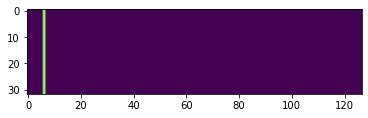

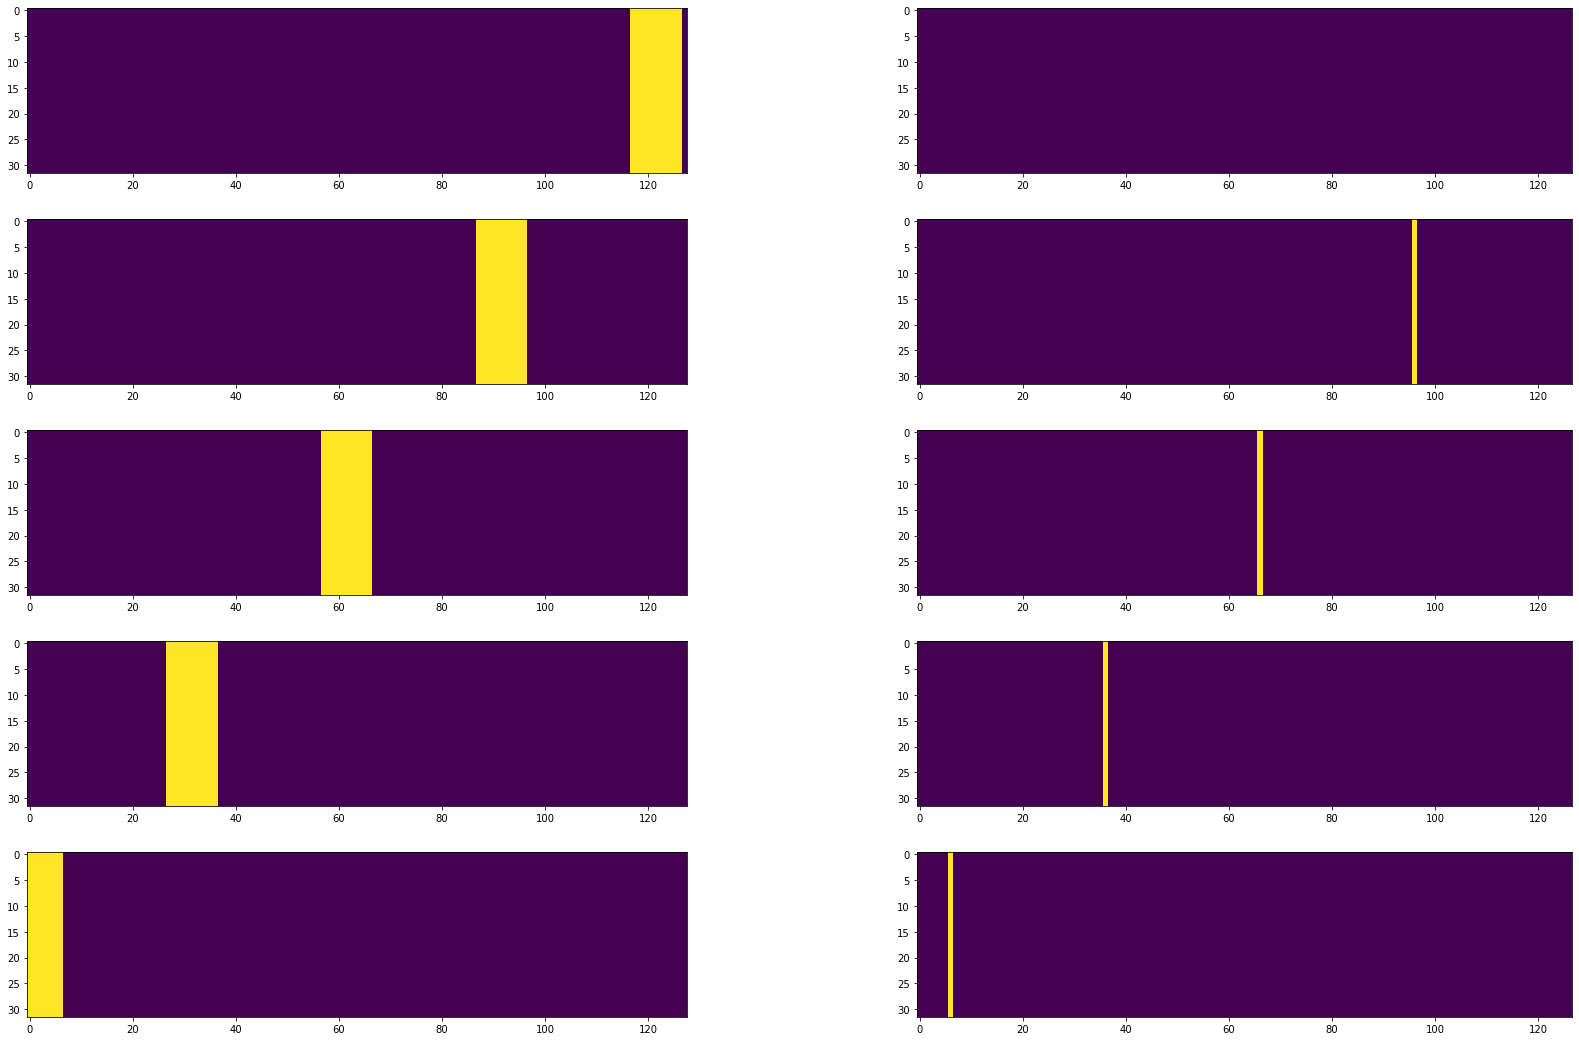

In [9]:
# TODO: Repeat the step above for a left moving bar
graph1 = HR_Detector(moving_bar1, direction = "left", func_left=lambda x: delay(x, 0), func_right=lambda x: delay(x, 10))

make_subplot(moving_bar1,graph1)


In [10]:
#BL detector

def gaussian(x, y=70, sig=10):
    return np.exp((np.power(x - y, 2.) / (2 * np.power(sig, 2.))))

def BL_detector(X, direction):

    height, width, time = X.shape
    gauss = np.zeros(time)
    filter_input = np.zeros((height,width,time))
    output = np.zeros((height,width-1,time))

    for i in range(time):
        gauss[i] = gaussian(i)
    
    for i in range(height):
        for j in range(width):
            filter_input[i,j,:] = np.convolve(X[i,j,:], gauss, mode = 'same')
        
    if direction == "right":
        for w in range(width-1):
            output[:,w,:] = filter_input[:,w,:] * X[:,w+1,:]
        
    elif direction == "left":
        for w in range(width-1):
            output[:,w,:] = filter_input[:,w+1,:] * X[:,w,:]
        
    return output

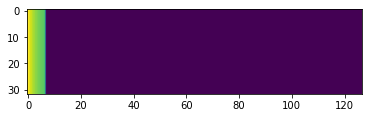

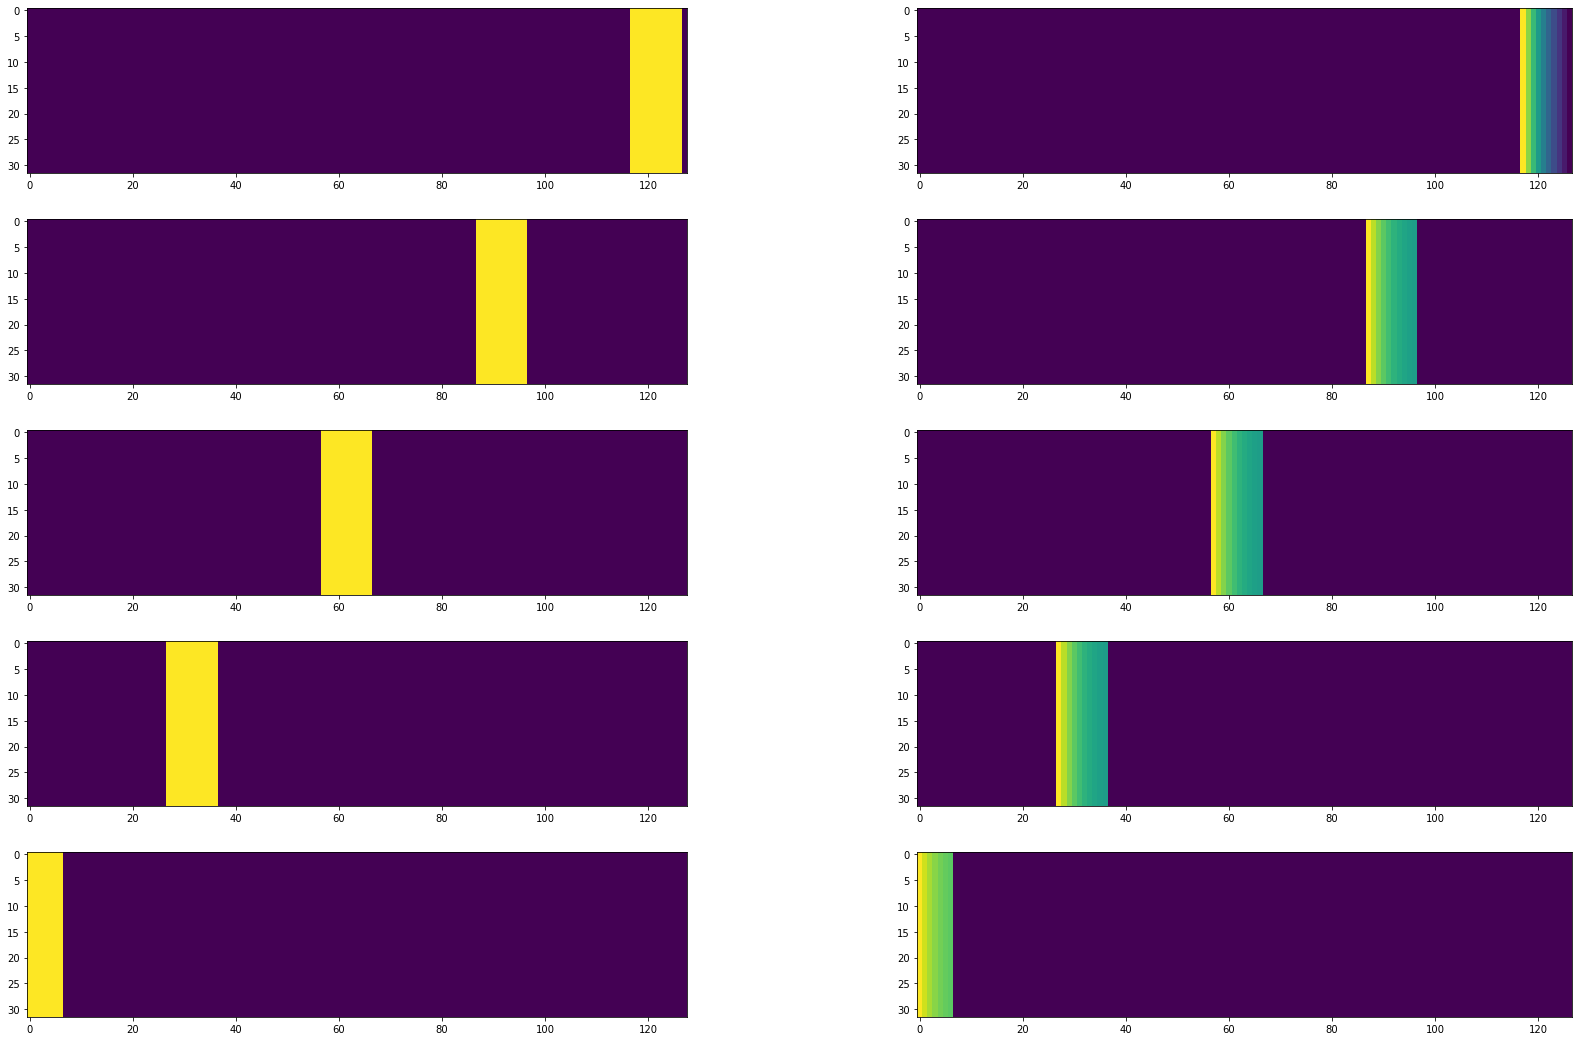

In [11]:
#BL detector left moving

BL_bar1 = generate_input(direction='left')
BL_graph1 = BL_detector(BL_bar1, 'left')
make_subplot(BL_bar1,BL_graph1)

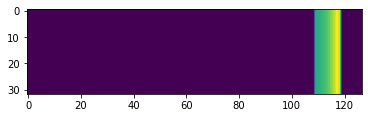

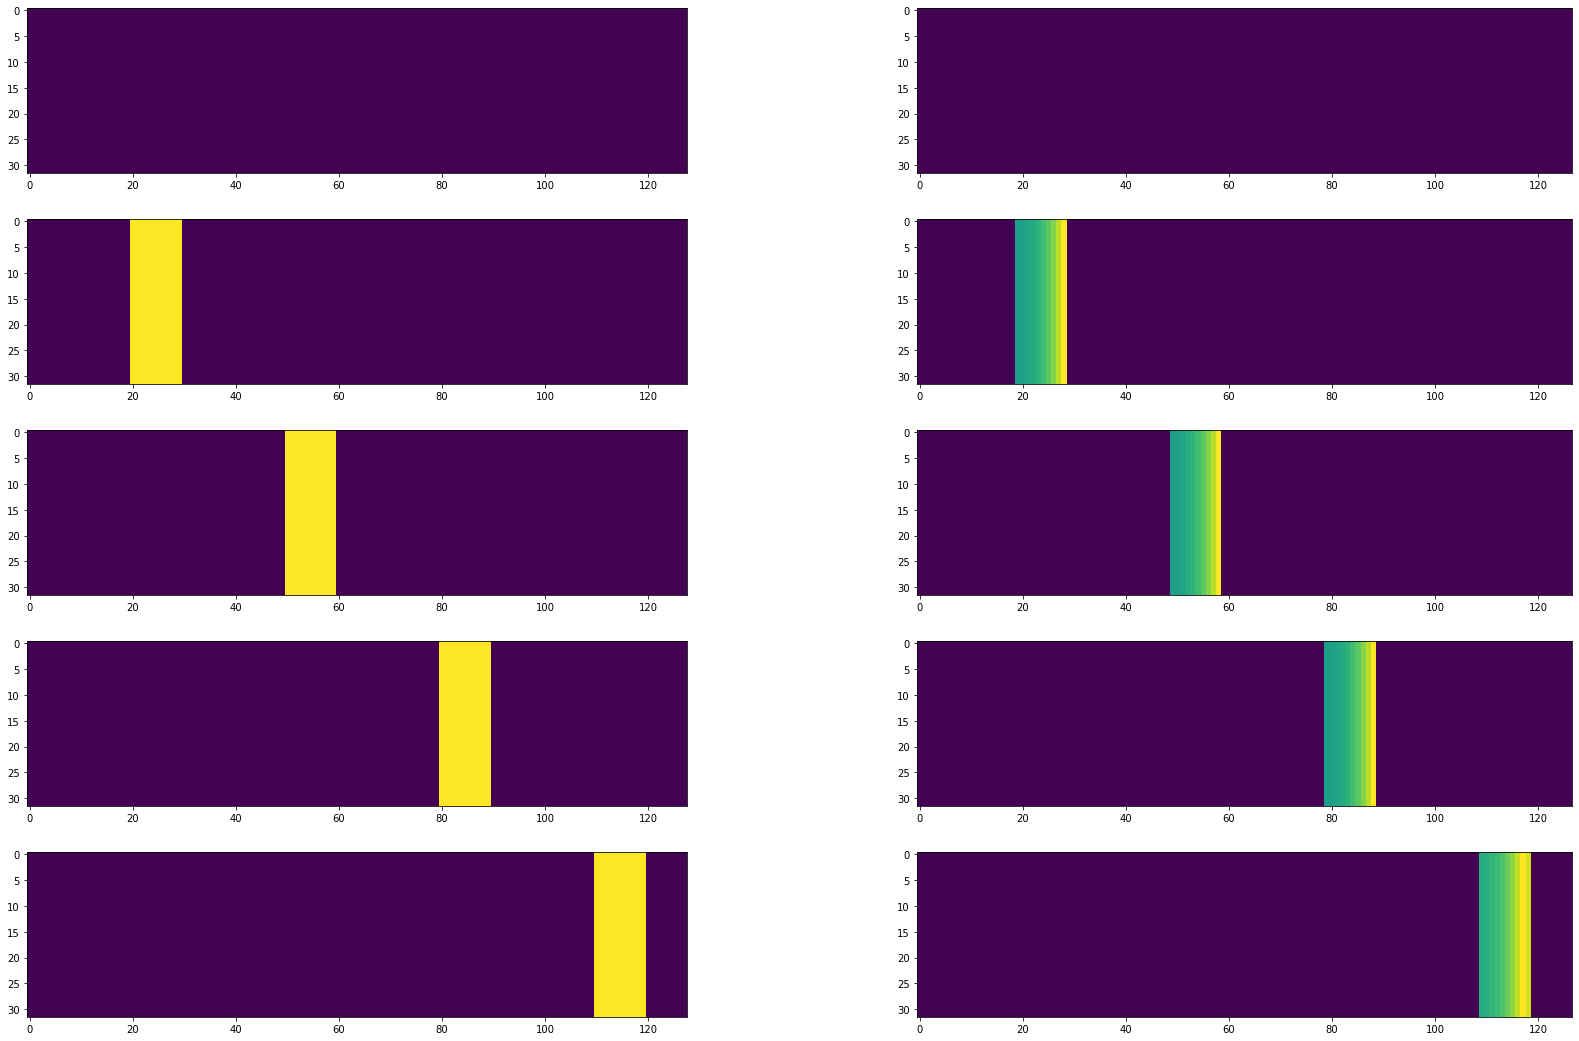

In [12]:
#BL detector right moving

BL_bar2 = generate_input(direction='right')
BL_graph2 = BL_detector(BL_bar2, 'right')
make_subplot(BL_bar2,BL_graph2)